In [1]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [2]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [3]:
!pip install ale-py==0.7


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.9 MB/s 


In [4]:
!pip install gym==0.19


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 4.9 MB/s 
  Created wheel for gym: filename=gym-0.19.0-py3-none-any.whl size=1663116 sha256=ec5485d5e4fe24af5f0d7f2afbd364a7838c38962828783c95f4ec589eff80d0
  Stored in directory: /root/.cache/pip/wheels/ef/9d/70/8bea53f7edec2fdb4f98d9d64ac9f11aea95dfcb98099d7712
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.17.3
    Uninstalling gym-0.17.3:
      Successfully uninstalled gym-0.17.3


In [5]:
!pip install gym[atari]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.8 MB 5.1 MB/s 
Reason for being yanked: re-release with new wheels
  Attempting uninstall: atari-py
    Found existing installation: atari-py 0.2.9
    Uninstalling atari-py-0.2.9:
      Successfully uninstalled atari-py-0.2.9


In [30]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [31]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
#import urllib.request


In [32]:
import gym
import cv2
from collections import deque,namedtuple
import numpy as np
import random
from keras.models import Sequential
from keras.layers import Conv2D,Flatten,Dense
#from keras.optimizers import Adam
from tensorflow.keras.optimizers import Adam

conv = namedtuple('Conv', 'filter kernel stride')

In [33]:
class Buffer:
	def __init__(self,size):
		self.size = size
		self.buffer = deque()
	def add(self,s,a,r,s2,t):
		s = np.stack((s[0],s[1],s[2],s[3]),axis=2)
		s2 = np.stack((s2[0],s2[1],s2[2],s2[3]),axis=2)
		if len(self.buffer) < self.size:
			self.buffer.appendleft((s,a,r,s2,t))
		else:
			self.buffer.pop()
			self.buffer.appendleft((s,a,r,s2,t))
	def sample(self,batch_size):
		return random.sample(self.buffer,batch_size)

In [34]:
class DQN:
	def __init__(self,buff,batch_size=32,min_buff=10000,gamma=0.99,learning_rate=2.5e-4):
		self.buffer = buff
		self.min_buffer = min_buff
		self.batch_size = batch_size
		self.gamma = gamma
		
		self.model = create_network(learning_rate)
		self.target_model = create_network(learning_rate)
		self.copy_network()

	def train(self):
		if len(self.buffer.buffer) < self.min_buffer:
			return
		states,actions,rewards,next_states,terminal = map(np.array,zip(*self.buffer.sample(self.batch_size)))
		next_state_action_values = np.max(self.target_model.predict(next_states),axis=1)
		targets = self.model.predict(states)
		targets[range(self.batch_size), actions] = rewards + self.gamma*next_state_action_values*np.invert(terminal)
		self.model.train_on_batch(states, targets)

	def copy_network(self):
		frm = self.model
		to = self.target_model
		for l_tg,l_sr in zip(to.layers,frm.layers):
			wk = l_sr.get_weights()
			l_tg.set_weights(wk)

	def predict(self,x):
		s = np.stack((x[0],x[1],x[2],x[3]),axis=2)
		return self.model.predict(np.array([s]))

In [35]:
def create_network(learning_rate,conv_info=[conv(32,8,4),conv(64,4,2),conv(64,3,1)],dense_info=[512],input_size=(80,80,4)):
	model = Sequential()
	for i,cl in enumerate(conv_info):
		if i==0:
			model.add(Conv2D(cl.filter,cl.kernel,padding="same",strides=cl.stride,activation="relu", input_shape=input_size))
		else:
			model.add(Conv2D(cl.filter,cl.kernel,padding="same",strides=cl.stride,activation="relu"))
	model.add(Flatten())
	for dl in dense_info:
		model.add(Dense(dl,activation="relu"))
	model.add(Dense(6))
	adam = Adam(lr=learning_rate)
	model.compile(loss='mse',optimizer=adam)
	return model

In [36]:
class Pong:
    def __init__(self):

        self.env = gym.make('PongNoFrameskip-v4')
        
        self.epsilon = 1
        self.memory = Buffer(500)
        self.dqn = DQN(self.memory)
        self.copy_period = 400
        self.itr = 0
        self.eps_step = 0.09
    def choose_action(self, s):
        if random.random() < self.epsilon:
            return self.env.action_space.sample()
        return np.argmax(self.dqn.predict(s)[0])
    def play_one_episode(self):
        start_time=time.time()
        observation = self.env.reset()  
        prev_screen = self.env.render(mode='rgb_array')
        plt.imshow(prev_screen)   
        done = False
        state = []
        update_state(state, observation)
        prv_state = []
        total_reward = 0
        while not done:
            screen = self.env.render(mode='rgb_array')
            plt.imshow(screen)
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
            
            if len(state) < 4:
                action = self.env.action_space.sample()
            else:
                action = self.choose_action(state)

            prv_state.append(state[-1])
            if len(prv_state) > 4:
                prv_state.pop(0)
            observation, reward, done, _ = self.env.step(action)

            update_state(state, observation)
            if len(state) == 4 and len(prv_state) == 4:
                self.memory.add(prv_state, action, reward, state, done)
            total_reward += reward

            self.itr += 1
            if self.itr % 4 == 0:
                self.dqn.train()
            self.epsilon = max(0.1, self.epsilon - self.eps_step)
            if self.itr % self.copy_period == 0:
                self.dqn.copy_network()


            ipythondisplay.clear_output(wait=True)

        end_time=time.time()
        print(f"time for episode{i} is {end_time-start_time}")
            
        return total_reward

In [37]:
import time
def downsample(observation):
	s = cv2.cvtColor(observation[30:,:,:], cv2.COLOR_BGR2GRAY)
	s = cv2.resize(s, (80,80), interpolation = cv2.INTER_AREA) 
	s = s/255.0
	return s
		
def update_state(state,observation):
	ds_observation = downsample(observation)
	state.append(ds_observation)
	if len(state) > 4:

		state.pop(0)

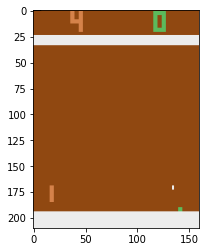

In [ ]:
p = Pong()
for i in range(100):
	total_reward = p.play_one_episode()
	print("episode total reward:",total_reward)
	if i%10 == 0:
		print("Saving the model")
		p.dqn.model.save("model-{}.h5".format(i))

In [ ]:
from IPython.display import clear_output , display
env = gym.make('PongNoFrameskip-v4')
env.reset()
p = Pong()
for i in range(100000):
	total_reward = p.play_one_episode()
	print("episode total reward:",total_reward)
	if i%100 == 0:
		print("Saving the model")
		p.dqn.model.save("model-{}.h5".format(i))

In [ ]:
env = gym.make("PongNoFrameskip-v4")
done=False

for i in range(5):
  env.reset()
  prev_screen = env.render(mode='rgb_array')
  plt.imshow(prev_screen)
  while not done:
        screen = env.render(mode='rgb_array')
        plt.imshow(screen)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())
        action = env.action_space.sample()
        obs, reward, done, info = env.step(action)
        if done:
                break


        ipythondisplay.clear_output(wait=True)
  
    
#env.close()

In [10]:
display.stop()

In [7]:
!mkdir shen
!ls

sample_data  shen
